In [1]:
import pandas as pd
import numpy as np
import numba as nb
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Use the csv with the infomration, which been taken from the raw data to build machine learning moduls. In this case, there would be 2 directions: 1st is to check if purchase amount can be predicted by session times(only with purchase cases), 2nd is to check if the modul can predict customer behaviour(only visiting website/purchase) with other features like purchase time, visit times, session times.

In [92]:
df=pd.read_csv('sessions.csv')
df

,Unnamed: 0,user_id,spent_time,month,day,hour,last_event,purchase_amount,nr_product,rank,sessiontime
0,355984,234044775,2887.0,12,1,0,purchase,41.39,5,1.0,2887.0
1,341079,252159723,1806.0,12,1,0,view,0.00,0,2.0,3360.0
2,590716,259408911,154.0,12,1,0,view,0.00,0,1.0,154.0
3,566609,348405118,464.0,12,1,0,cart,0.00,0,1.0,464.0
4,424132,356011474,2923.0,12,1,0,purchase,56.91,31,1.0,2923.0
...,...,...,...,...,...,...,...,...,...,...,...
248549,618580,595411525,108.0,12,31,23,view,0.00,0,1.0,108.0
248550,374356,595411904,125.0,12,31,23,view,0.00,0,4.0,465.0
248551,713300,595412191,251.0,12,31,23,cart,0.00,0,1.0,251.0
248552,804770,595412617,706.0,12,31,23,view,0.00,0,1.0,706.0


In [93]:
df.columns

Index(['Unnamed: 0', 'user_id', 'spent_time', 'month', 'day', 'hour',
       'last_event', 'purchase_amount', 'nr_product', 'rank', 'sessiontime'],
      dtype='object')

In [94]:
df=df.drop(columns=['Unnamed: 0','spent_time'])
df

,user_id,month,day,hour,last_event,purchase_amount,nr_product,rank,sessiontime
0,234044775,12,1,0,purchase,41.39,5,1.0,2887.0
1,252159723,12,1,0,view,0.00,0,2.0,3360.0
2,259408911,12,1,0,view,0.00,0,1.0,154.0
3,348405118,12,1,0,cart,0.00,0,1.0,464.0
4,356011474,12,1,0,purchase,56.91,31,1.0,2923.0
...,...,...,...,...,...,...,...,...,...
248549,595411525,12,31,23,view,0.00,0,1.0,108.0
248550,595411904,12,31,23,view,0.00,0,4.0,465.0
248551,595412191,12,31,23,cart,0.00,0,1.0,251.0
248552,595412617,12,31,23,view,0.00,0,1.0,706.0


In [95]:
df['purchase_amount']=df['purchase_amount'].apply(lambda x:round(x,2))
df

,user_id,month,day,hour,last_event,purchase_amount,nr_product,rank,sessiontime
0,234044775,12,1,0,purchase,41.39,5,1.0,2887.0
1,252159723,12,1,0,view,0.00,0,2.0,3360.0
2,259408911,12,1,0,view,0.00,0,1.0,154.0
3,348405118,12,1,0,cart,0.00,0,1.0,464.0
4,356011474,12,1,0,purchase,56.91,31,1.0,2923.0
...,...,...,...,...,...,...,...,...,...
248549,595411525,12,31,23,view,0.00,0,1.0,108.0
248550,595411904,12,31,23,view,0.00,0,4.0,465.0
248551,595412191,12,31,23,cart,0.00,0,1.0,251.0
248552,595412617,12,31,23,view,0.00,0,1.0,706.0


In [96]:
df['last_event'].value_counts()

view                170693
cart                 38178
purchase             21382
remove_from_cart     18301
Name: last_event, dtype: int64

In [97]:
df['last_event']=np.where(df['last_event']=='purchase','purchase','view')
df

,user_id,month,day,hour,last_event,purchase_amount,nr_product,rank,sessiontime
0,234044775,12,1,0,purchase,41.39,5,1.0,2887.0
1,252159723,12,1,0,view,0.00,0,2.0,3360.0
2,259408911,12,1,0,view,0.00,0,1.0,154.0
3,348405118,12,1,0,view,0.00,0,1.0,464.0
4,356011474,12,1,0,purchase,56.91,31,1.0,2923.0
...,...,...,...,...,...,...,...,...,...
248549,595411525,12,31,23,view,0.00,0,1.0,108.0
248550,595411904,12,31,23,view,0.00,0,4.0,465.0
248551,595412191,12,31,23,view,0.00,0,1.0,251.0
248552,595412617,12,31,23,view,0.00,0,1.0,706.0


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248554 entries, 0 to 248553
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          248554 non-null  int64  
 1   month            248554 non-null  int64  
 2   day              248554 non-null  int64  
 3   hour             248554 non-null  int64  
 4   last_event       248554 non-null  object 
 5   purchase_amount  248554 non-null  float64
 6   nr_product       248554 non-null  int64  
 7   rank             248554 non-null  float64
 8   sessiontime      248554 non-null  float64
dtypes: float64(3), int64(5), object(1)
memory usage: 17.1+ MB


In [99]:
# convert session time from seconds to minutes
df['sessiontime']=df['sessiontime'].apply(lambda x:round(x/60,2))
df

,user_id,month,day,hour,last_event,purchase_amount,nr_product,rank,sessiontime
0,234044775,12,1,0,purchase,41.39,5,1.0,48.12
1,252159723,12,1,0,view,0.00,0,2.0,56.00
2,259408911,12,1,0,view,0.00,0,1.0,2.57
3,348405118,12,1,0,view,0.00,0,1.0,7.73
4,356011474,12,1,0,purchase,56.91,31,1.0,48.72
...,...,...,...,...,...,...,...,...,...
248549,595411525,12,31,23,view,0.00,0,1.0,1.80
248550,595411904,12,31,23,view,0.00,0,4.0,7.75
248551,595412191,12,31,23,view,0.00,0,1.0,4.18
248552,595412617,12,31,23,view,0.00,0,1.0,11.77


In [100]:
df=df.drop(df[(df['last_event']=='view')& (df['purchase_amount']!=0)].index)
df

,user_id,month,day,hour,last_event,purchase_amount,nr_product,rank,sessiontime
0,234044775,12,1,0,purchase,41.39,5,1.0,48.12
1,252159723,12,1,0,view,0.00,0,2.0,56.00
2,259408911,12,1,0,view,0.00,0,1.0,2.57
3,348405118,12,1,0,view,0.00,0,1.0,7.73
4,356011474,12,1,0,purchase,56.91,31,1.0,48.72
...,...,...,...,...,...,...,...,...,...
248549,595411525,12,31,23,view,0.00,0,1.0,1.80
248550,595411904,12,31,23,view,0.00,0,4.0,7.75
248551,595412191,12,31,23,view,0.00,0,1.0,4.18
248552,595412617,12,31,23,view,0.00,0,1.0,11.77


In [101]:
df.to_csv('df_viz.csv')

In [102]:
def day_time(df):
    for i in range(len(df)):
        if 0<= df['hour'].iloc[i]<=6:
            df['hour'].iloc[i]='midnight'
        elif 7<= df['hour'].iloc[i] <=12:
            df['hour'].iloc[i]='morning'
        elif 13<= df['hour'].iloc[i] <=18:
            df['hour'].iloc[i]='afternoon'
        else:
            df['hour'].iloc[i]='night'
    return df

In [103]:
df=day_time(df)
df

,user_id,month,day,hour,last_event,purchase_amount,nr_product,rank,sessiontime
0,234044775,12,1,midnight,purchase,41.39,5,1.0,48.12
1,252159723,12,1,midnight,view,0.00,0,2.0,56.00
2,259408911,12,1,midnight,view,0.00,0,1.0,2.57
3,348405118,12,1,midnight,view,0.00,0,1.0,7.73
4,356011474,12,1,midnight,purchase,56.91,31,1.0,48.72
...,...,...,...,...,...,...,...,...,...
248549,595411525,12,31,night,view,0.00,0,1.0,1.80
248550,595411904,12,31,night,view,0.00,0,4.0,7.75
248551,595412191,12,31,night,view,0.00,0,1.0,4.18
248552,595412617,12,31,night,view,0.00,0,1.0,11.77


In [90]:
df['last_event'].value_counts()

view        225459
purchase     21382
Name: last_event, dtype: int64

In [91]:
df_ml=df.drop(columns=['month','user_id','day'],axis=1).reset_index(drop=True)
df_ml

,hour,last_event,purchase_amount,nr_product,rank,sessiontime
0,midnight,purchase,41.39,5,1.0,48.12
1,midnight,view,0.00,0,2.0,56.00
2,midnight,view,0.00,0,1.0,2.57
3,midnight,view,0.00,0,1.0,7.73
4,midnight,purchase,56.91,31,1.0,48.72
...,...,...,...,...,...,...
246836,night,view,0.00,0,1.0,1.80
246837,night,view,0.00,0,4.0,7.75
246838,night,view,0.00,0,1.0,4.18
246839,night,view,0.00,0,1.0,11.77


In [16]:
df_ml = pd.get_dummies(df_ml, columns=['last_event','hour'], drop_first=True)
df_ml

,purchase_amount,nr_product,rank,sessiontime,last_event_view,hour_midnight,hour_morning,hour_night
0,41.39,5,1.0,48.12,0,1,0,0
1,0.00,0,2.0,56.00,1,1,0,0
2,0.00,0,1.0,2.57,1,1,0,0
3,0.00,0,1.0,7.73,1,1,0,0
4,56.91,31,1.0,48.72,0,1,0,0
...,...,...,...,...,...,...,...,...
246836,0.00,0,1.0,1.80,1,0,0,1
246837,0.00,0,4.0,7.75,1,0,0,1
246838,0.00,0,1.0,4.18,1,0,0,1
246839,0.00,0,1.0,11.77,1,0,0,1


In [17]:
df_corr=df_ml[['nr_product','purchase_amount','rank','sessiontime']]

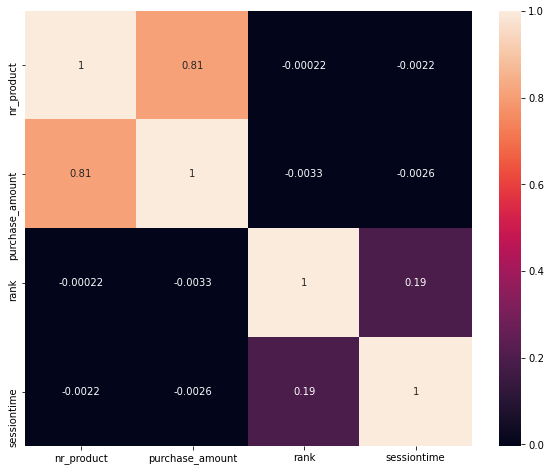

In [18]:
corr_matrix=df_corr.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

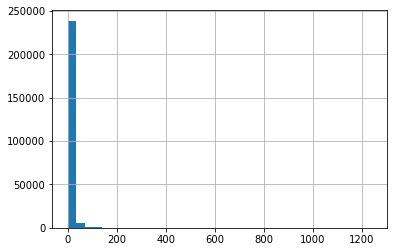

In [19]:
df_ml['purchase_amount'].hist(bins=35)

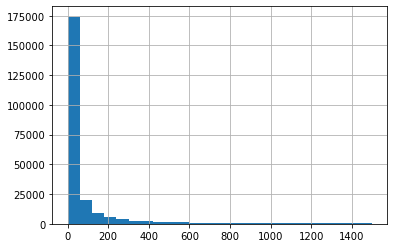

In [20]:
df_ml['sessiontime'].hist(bins=25,range=(0,1500))

Making Classification Modul. The codes only showinng Undersampler, but tried also with SMOTE and the result showed same, so codes didn't show here.

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score

In [22]:
df_ml['last_event_view'].value_counts()

1    225459
0     21382
Name: last_event_view, dtype: int64

In [23]:
scaler=StandardScaler()
rus = RandomUnderSampler()

In [24]:
y=df_ml['last_event_view']

In [25]:
X=scaler.fit_transform(df_ml.drop('last_event_view', axis=1))

In [26]:
X_res, y_res = rus.fit_resample(X,y)

In [27]:
y_res.value_counts()

1    21382
0    21382
Name: last_event_view, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=17)

In [29]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)
print(classification_report(y_test, pred))
print(accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7032
           1       1.00      1.00      1.00      7081

    accuracy                           1.00     14113
   macro avg       1.00      1.00      1.00     14113
weighted avg       1.00      1.00      1.00     14113

1.0


In [30]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [31]:
y_pred_class = logreg.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7032
           1       1.00      1.00      1.00      7081

    accuracy                           1.00     14113
   macro avg       1.00      1.00      1.00     14113
weighted avg       1.00      1.00      1.00     14113



In [32]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [33]:
y_pred = classifier.predict(X_test)

In [34]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[7025    7]
 [   0 7081]]


0.9995040034011196

Making Linear Regression Modul

In [35]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [36]:
df_lin=df.drop(df[df['last_event']!='purchase'].index)
df_lin

,user_id,month,day,hour,last_event,purchase_amount,nr_product,rank,sessiontime
0,234044775,12,1,midnight,purchase,41.39,5,1.0,48.12
4,356011474,12,1,midnight,purchase,56.91,31,1.0,48.72
5,361564578,12,1,midnight,purchase,17.46,1,1.0,36.45
14,433063720,12,1,midnight,purchase,81.52,8,1.0,7.48
16,436271415,12,1,midnight,purchase,70.49,17,1.0,42.98
...,...,...,...,...,...,...,...,...,...
248354,532286277,12,31,night,purchase,194.44,1,3.0,15.10
248376,581329286,12,31,night,purchase,94.44,1,1.0,6.85
248388,595376179,12,31,night,purchase,46.49,9,4.0,271.80
248474,231690364,12,31,night,purchase,14.44,2,38.0,13.58


In [37]:
df_lin=df_lin.drop(columns=['user_id','month','last_event',],axis=1).reset_index(drop=True)
df_lin

,day,hour,purchase_amount,nr_product,rank,sessiontime
0,1,midnight,41.39,5,1.0,48.12
1,1,midnight,56.91,31,1.0,48.72
2,1,midnight,17.46,1,1.0,36.45
3,1,midnight,81.52,8,1.0,7.48
4,1,midnight,70.49,17,1.0,42.98
...,...,...,...,...,...,...
21377,31,night,194.44,1,3.0,15.10
21378,31,night,94.44,1,1.0,6.85
21379,31,night,46.49,9,4.0,271.80
21380,31,night,14.44,2,38.0,13.58


In [38]:
df_lin=pd.get_dummies(df_lin, columns=['hour'], drop_first=True)
df_lin

,day,purchase_amount,nr_product,rank,sessiontime,hour_midnight,hour_morning,hour_night
0,1,41.39,5,1.0,48.12,1,0,0
1,1,56.91,31,1.0,48.72,1,0,0
2,1,17.46,1,1.0,36.45,1,0,0
3,1,81.52,8,1.0,7.48,1,0,0
4,1,70.49,17,1.0,42.98,1,0,0
...,...,...,...,...,...,...,...,...
21377,31,194.44,1,3.0,15.10,0,0,1
21378,31,94.44,1,1.0,6.85,0,0,1
21379,31,46.49,9,4.0,271.80,0,0,1
21380,31,14.44,2,38.0,13.58,0,0,1


y_lin=df_lin['purchase_amount']

In [76]:
X_lin=df_lin.drop(columns=['purchase_amount','day','nr_product','sessiontime','rank','hour_midnight','hour_morning',],axis=1)

In [77]:
X_lin=sm.add_constant(X_lin)
model=sm.OLS(y_lin,X_lin).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        purchase_amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2455
Date:                Tue, 15 Dec 2020   Prob (F-statistic):              0.620
Time:                        10:03:11   Log-Likelihood:            -1.0975e+05
No. Observations:               21382   AIC:                         2.195e+05
Df Residuals:                   21380   BIC:                         2.195e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.7087      0.309    118.711      0.0

#

The results from both moduls showed that there are no correlations between different features. Either customers are more depending on their subjective consciousness or the data from one month is not enough for the moduls. But it still shows some important information, like most purchases happened on monday mornings, and people like to shop during working time. 